In [32]:
import numpy as np
import tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from scipy.spatial import distance
from sklearn.metrics import calinski_harabaz_score, silhouette_score
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from scipy.spatial import distance

methods_dict = {'dbscan':DBSCAN,
               'KMeans':KMeans,
               'SpectralClustering':SpectralClustering}

params_dict = {'dbscan':np.linspace(0.1, 2.0, 20),
               'KMeans':np.arange(2, 10, 1),
               'SpectralClustering':np.arange(3, 12, 2)}

In [33]:
# paths to the databases containing the PCA and Isomap projections 
root_pca = './separate_datasets_data'
paths = [os.path.join(root_pca,path) for path in os.listdir(root_pca)]
# paths = paths_pca + paths_mf
paths_pca = list(filter(lambda x: 'err' not in x.split("/")[-1].split(".")[0].split('_'), paths))
paths_mf = list(filter(lambda x: 'err' in x.split("/")[-1].split(".")[0].split('_'), paths))

In [ ]:
for p in paths:
    label = p.split("/")[-1].split(".")[0]
    s = label.split('_')
    if 'err' in s:
        d = s[0]
        t = s[2]
        dim = s[5]
        method = s[3]
        print(f'Dataset: {d}, tax: {t}, manifold_method: {method}, intrinsic_dim: {dim}')

In [13]:
# Davies Bouldin Index
def DB_index(X, clusters_centers, labels):
    if -1 in labels:
        X = X[labels != -1]
        labels = labels[labels != -1]
    n_clusters = len(clusters_centers)
    d = np.array([distance.euclidean(X[i], clusters_centers[labels[i]]) for i in range(len(X))])
    mean_dist = np.zeros(n_clusters)
    for i in range(n_clusters):
        mean_dist[i] = d[labels == i].mean()
    return sum([max([(mean_dist[i] + mean_dist[j]) / distance.euclidean(clusters_centers[i], clusters_centers[j]) 
         for i in range(n_clusters) if i != j]) for j in range(n_clusters)]) / n_clusters

In [14]:
# Clusters centers
def cl_centers(X, pred, n_cl=None):
    if n_cl is None:
        n_cl = len(set(pred))
        if -1 in pred:
            n_cl -= 1
    centers = np.zeros((n_cl, X.shape[1]))
    for i in range(n_cl):
        centers[i] = X[pred == i].mean(0)
    return centers

In [15]:
# sample the data via binomial mask
def sample_data(data, fraction):
    mask = np.random.binomial(1, fraction, data.shape[0]).astype(bool)
    return data[mask]

In [16]:
def plot_pca_proj_clustering(clustering_results, suptitle=None):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
    for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
        for j,tax_name in enumerate(['o', 'f', 'g']):
            label = f'{dataset_name}_proj_{tax_name}'
            data = clustering_results[label]
            df = pd.DataFrame(data=data).T
            df.columns = ['Davies-Bouldin index', 'silhouette_score']
            df.sort_index(ascending=False, inplace=True)
            ax = axes[i,j]
            ax.set_xlabel('# estimated clusters')
            ax.set_title(label)
            df.plot.bar(ax=ax)
    
    plt.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, color='blue')
    plt.show()

In [ ]:
def get_path(label, paths):
    for p in paths:
        'ibd_proj_g_isomap_dim_5_err_0-0448'
        'ibd_proj_f.csv'
        dataname = ''.join(path.split("/")[-1].split(".")[0].split('_'))
        if ''.join(label.split('_')) == dataname:
            return p
        else:
            raise RuntimeError()
def plot_tsne_2(paths, manifold_method='', suptitle=None):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,15))
    for i,dataset_name in enumerate(['ptb', 'AGP', 't2d', 'ibd']):
        for j,tax_name in enumerate(['o', 'f', 'g']):
            use_mf = manifold_method != ''
            'ibd_proj_f_isomap_dim_4_err_0-0664.csv'
            'ibd_proj_f.csv'
            label = f'{dataset_name}_proj_{tax_name}' + '_' + manifold_method if use_mf
            path = get_path(label,paths)
            data = np.genfromtxt(path, delimiter=';')
            ax = axes[i,j]
            ax.scatter(data[:,0], data[:,1])
            ax.set_title(label)
    plt.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16, color='blue')
    plt.show()

In [18]:
def clustering(paths, method_class, param_range):
    # performing clustering
    cluster_results = defaultdict(dict)
    for path in tqdm.tqdm_notebook(paths):
        dataset = np.genfromtxt(path, delimiter=';')
        label = path.split("/")[-1].split(".")[0]
        for p in param_range:
            method = method_class(p)
            pred = method.fit_predict(dataset)
            if max(pred) > 0:
                centers = cl_centers(dataset, pred)
                ind = DB_index(dataset, centers, pred)
                silh = silhouette_score(dataset, pred)
                n = len(np.unique(pred[pred != -1]))

            cluster_results[label][n] = [ind, silh]
    return cluster_results

# DBSCAN

In [19]:
# Performing DBScan clustering
dbscan_results = defaultdict(dict)
dbscan_output = defaultdict(dict)
for path in tqdm.tqdm_notebook(paths_pca):
    dataset = np.genfromtxt(path, delimiter=';')
    label = path.split("/")[-1].split(".")[0]
    indexes = []
    for eps in np.linspace(0.1, 2.0, 20):
        d = {}
        dbscan = DBSCAN(eps)
        pred = dbscan.fit_predict(dataset)
        if max(pred) > 0:
            centers = cl_centers(dataset, pred)
            ind = DB_index(dataset, centers, pred)
            silh = silhouette_score(dataset, pred)
            n = len(np.unique(pred[pred != -1]))
            d['eps'] = eps
            d['dbindex'] = ind
            d['silhouette_score'] = silh
            d['classes'] = n
            d['Classified_samples_ratio'] = (pred != -1).sum() / len(pred)

            indexes.append(ind)
        else:
            indexes.append(-1)
            
        dbscan_results[label][n] = [ind, silh]
        dbscan_output[label][eps] = d

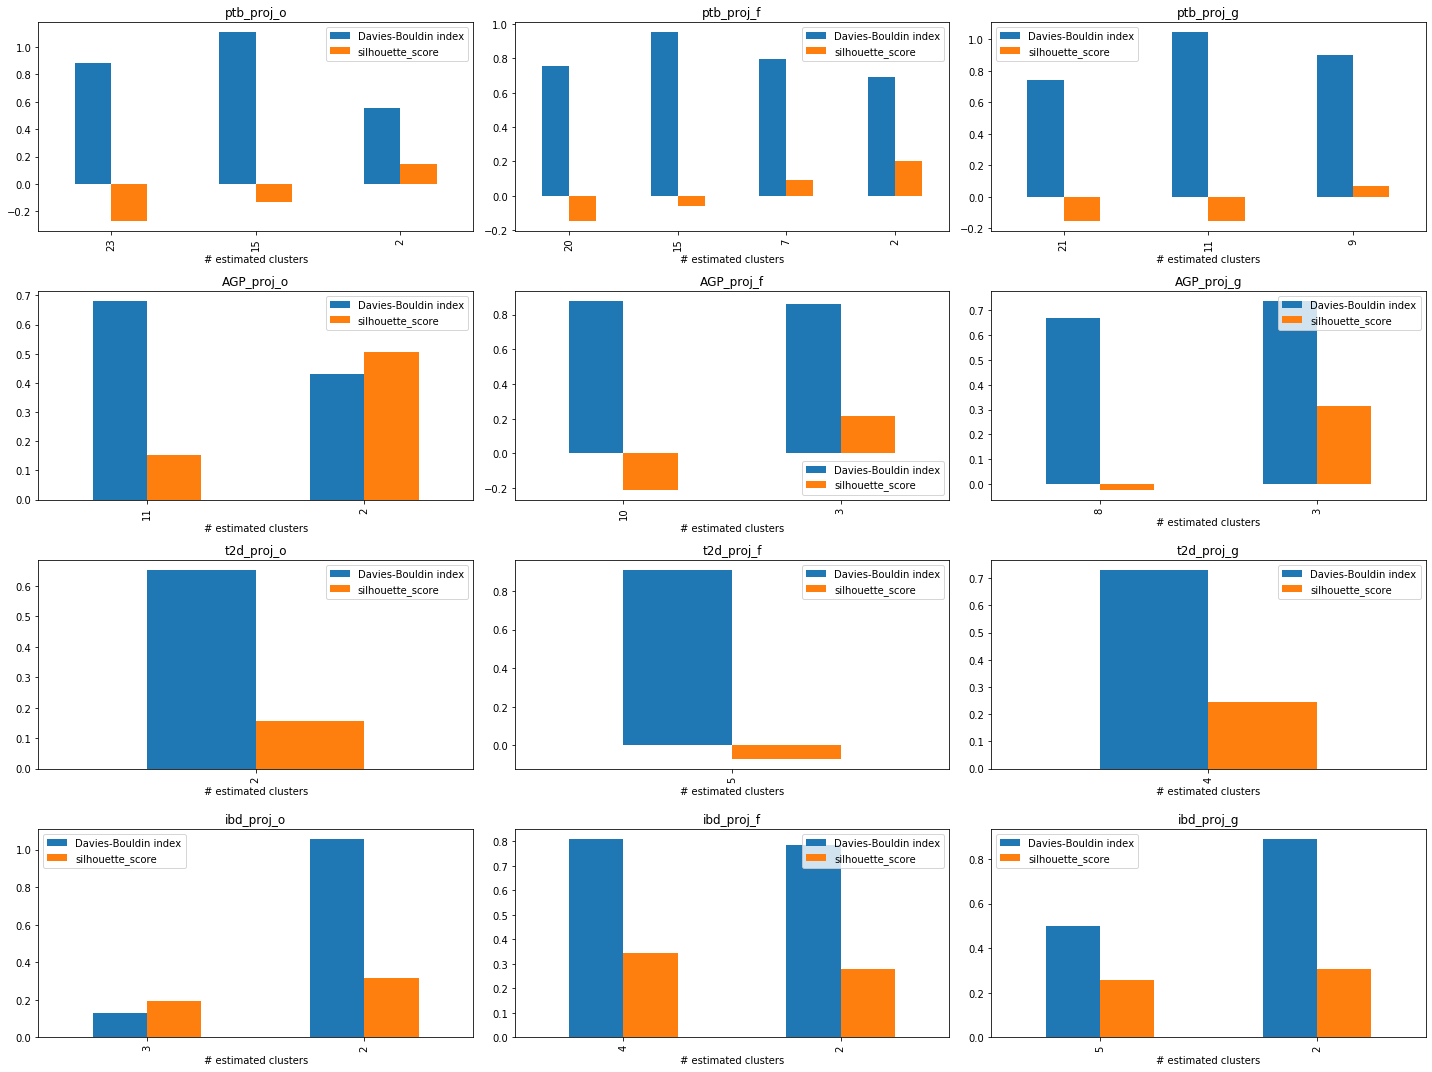

In [20]:
plot_pca_proj_clustering(dbscan_results)

# KMEANS

In [21]:
# performing K-Means Clustering
kmeans_results = defaultdict(dict)
kmeans_output = defaultdict(dict)
for path in tqdm.tqdm_notebook(paths_pca):
    dataset = np.genfromtxt(path, delimiter=';')
    label = path.split("/")[-1].split(".")[0]
    indexes = []
    for n in np.arange(2, 10, 1):
        d = {}
        kmeans = KMeans(int(n))
        pred = kmeans.fit_predict(dataset)
        if max(pred) > 0:
            centers = cl_centers(dataset, pred)
            silh = silhouette_score(dataset, pred)
            ind = DB_index(dataset, centers, pred)
            n = len(np.unique(pred[pred != -1]))
                                    
            d['n'] = n
            d['dbindex'] = ind
            d['silhouette_score'] = silh
            d['classes'] = n
            d['Classified_samples_ratio'] = (pred != -1).sum() / len(pred)
            
            indexes.append(ind)
        else:
            indexes.append(-1)
        
        kmeans_results[label][n] = [ind, silh]
        kmeans_output[label][n] = d

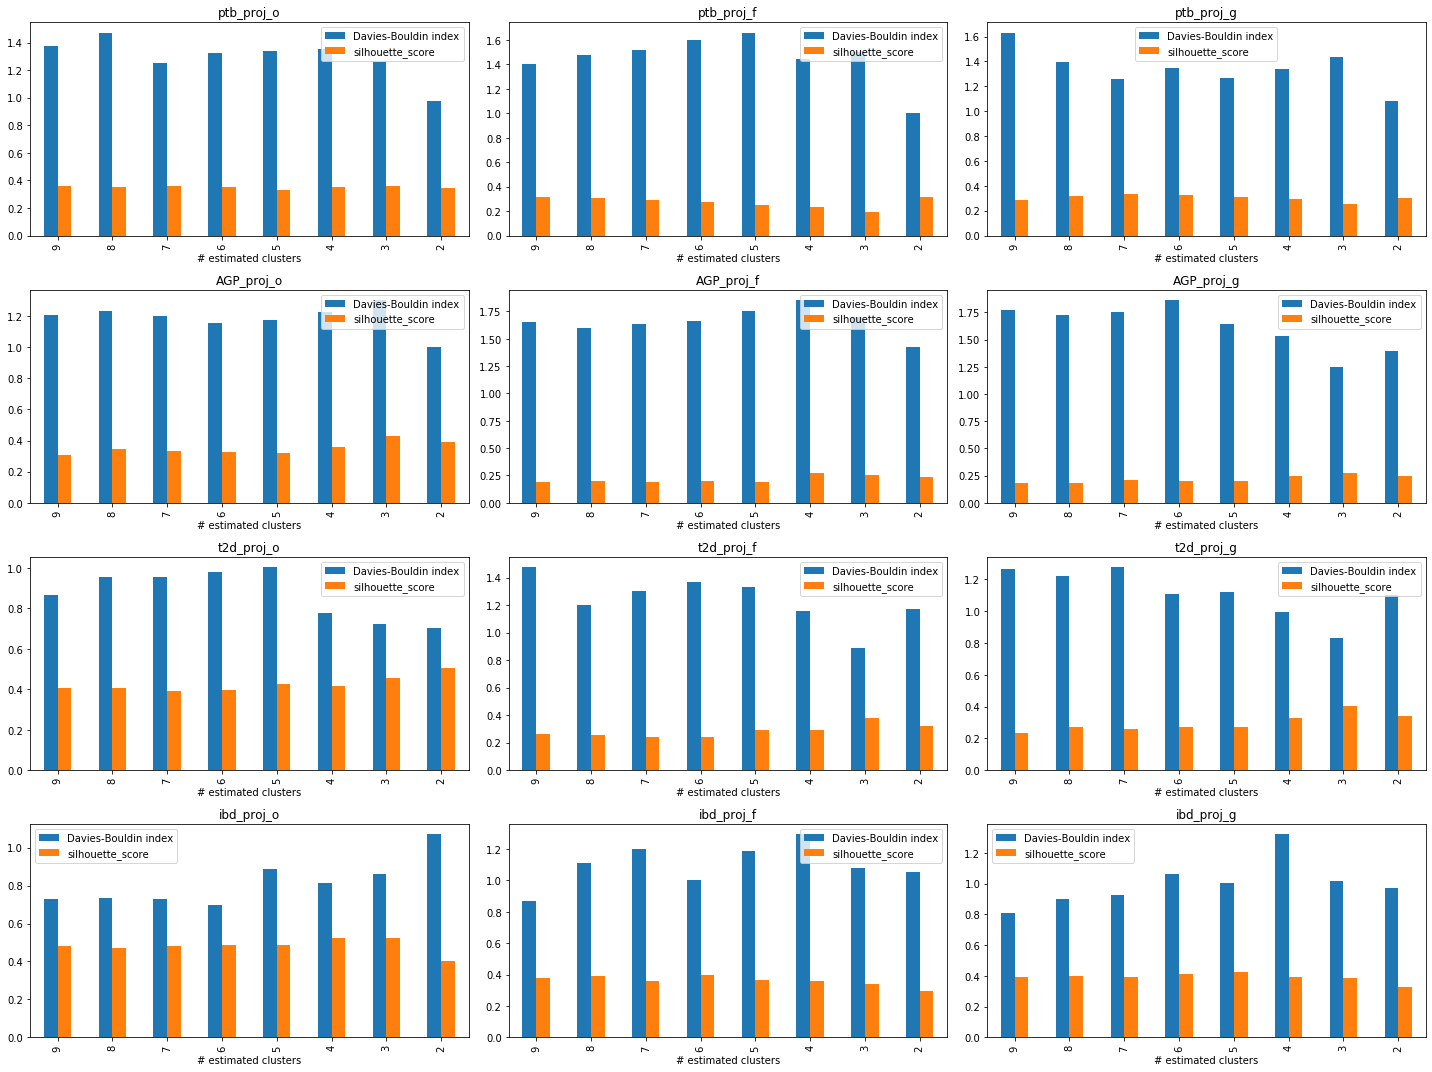

In [22]:
plot_pca_proj_clustering(kmeans_results)

# Spectral Clustering

In [23]:
# performing Spectral Clustering
spectral_results = defaultdict(dict)
spectral_output = defaultdict(dict)
for path in tqdm.tqdm_notebook(paths_pca):
    dataset = np.genfromtxt(path, delimiter=';')
    label = path.split("/")[-1].split(".")[0]
    indexes = []
    for n in np.arange(3, 12, 2):
        sp = SpectralClustering(int(n))
        d = {}
        pred = sp.fit_predict(dataset)
        if max(pred) > 0:
            centers = cl_centers(dataset, pred)
            ind = DB_index(dataset, centers, pred)
            silh = silhouette_score(dataset, pred)
            n = len(np.unique(pred[pred != -1]))
            d['n'] = eps
            d['dbindex'] = ind
            d['silhouette_score'] = silh
            d['classes'] = n
            d['Classified_samples_ratio'] = (pred != -1).sum() / len(pred)
            
            indexes.append(ind)
        else:
            indexes.append(-1)
            
        spectral_results[label][n] = [ind, silh]
        spectral_output[label][eps] = d


KeyboardInterrupt: 

In [ ]:
plot_pca_proj_clustering(spectral_results)

# Aggregation

In [ ]:
methods_names = list(methods_dict.keys())
datasets_names = sorted(list(spectral_results.keys()))

def create_clustering_pivot_table(results_list, methods_names, datasets_names):
    all_results = dict(zip(methods_names, results_list))
    X_dbind =np.zeros((len(methods_names), len(datasets_names)))
    X_silh =np.zeros((len(methods_names), len(datasets_names)))

    for i,(method_name) in tqdm.tqdm_notebook(enumerate(methods_names)):
        for j,(dataset_name) in enumerate(datasets_names):
            r = all_results[method_name][dataset_name]
            n_dbind = sorted(r, key=lambda x: r[x][0])[0] # minimized
            n_silh = sorted(r, key=lambda x: r[x][1])[-1] # maximized

            X_dbind[i,j] = n_dbind
            X_silh[i,j] = n_silh
    X_dbind = pd.DataFrame(data = X_dbind, columns=datasets_names, index=methods_names)
    X_silh = pd.DataFrame(data = X_silh, columns=datasets_names, index=methods_names)
    return X_dbind, X_silh

In [ ]:
X_dbind, X_silh = create_clustering_pivot_table([dbscan_results, kmeans_results, spectral_results], methods_names, datasets_names)

# For ISOMAP

In [ ]:
paths_mf = [os.path.join(root_mf,path) for path in os.listdir(root_mf)]
isomap_cluster_results_list = []
for mf_method_name in ['isomap']:    
    for method_name in methods_names:
        method_class = methods_dict[method_name]
        param_range = params_dict[method_name]
        cluster_results = clustering(paths, method_class, param_range)
        plot_pca_proj_clustering(cluster_results, suptitle=method_name)
        isomap_cluster_results_list.append(cluster_results)

In [ ]:
X_dbind_isomap, X_silh_isomap = create_clustering_pivot_table(isomap_cluster_results_list, methods_names, datasets_names)

# LLE

In [ ]:
paths_mf = [os.path.join(root_mf,path) for path in os.listdir(root_mf)]
lle_cluster_results_list = []
for mf_method_name in ['lle']:    
    for method_name in methods_names:
        method_class = methods_dict[method_name]
        param_range = params_dict[method_name]
        cluster_results = clustering(paths, method_class, param_range)
        plot_pca_proj_clustering(cluster_results, suptitle=method_name)
        lle_cluster_results_list.append(cluster_results)

In [ ]:
X_dbind_lle, X_silh_lle = create_clustering_pivot_table(lle_cluster_results_list, methods_names, datasets_names)

# Aggregated pivot tables: DBIND

In [ ]:
X_dbind_lle.index = [i + '_lle' for i in X_dbind_lle.index]
X_dbind_isomap.index = [i + '_isomap' for i in X_dbind_isomap.index]

In [ ]:
X_dbind_all = pd.concat([X_dbind, X_dbind_lle, X_dbind_isomap], axis = 0)
X_dbind_all

# Aggregated pivot tables: SILHOETTE

In [ ]:
X_silh_lle.index = [i + '_lle' for i in X_silh_lle.index]
X_silh_isomap.index = [i + '_isomap' for i in X_silh_isomap.index]
X_silh_all = pd.concat([X_silh, X_silh_lle, X_silh_isomap], axis = 0)
X_silh_all

# Visualisation

In [189]:
from sklearn.manifold import TSNE

for path in tqdm.tqdm_notebook(paths):
    dataset = np.genfromtxt(path, delimiter=';')
    label = path.split("/")[-1].split(".")[0]
    
    tsne2 = TSNE(2)
    tsne2.fit_transform(dataset)
    
    plt.figure()
    plt.scatter(data_transformed[:,0], data_transformed[:,1], alpha=0.1)
    